In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, fft, stats
from scipy.special import gamma, kv  # 修正的贝塞尔函数
import warnings
import time
warnings.filterwarnings('ignore')

# 设置matplotlib中文显示和图像质量
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print("所有必要的库已导入完成")

所有必要的库已导入完成


In [37]:
class CharacteristicFunction:
    """特征函数基类"""
    def phi(self, u):
        raise NotImplementedError
    
    def phi_h(self, u, h):
        """h时间步长的特征函数"""
        return np.power(self.phi(u), h)

class StudentTCharFunc(CharacteristicFunction):
    """简化但稳定的Student-t特征函数实现"""
    def __init__(self, mu, sigma, nu):
        self.mu = mu
        self.sigma = sigma
        self.nu = nu
    
    def phi(self, u):
        """
        使用简化但数值稳定的Student-t特征函数
        基于经验公式，确保数值稳定性
        """
        u = np.asarray(u)
        result = np.zeros_like(u, dtype=complex)
        
        # u=0时
        zero_mask = (np.abs(u) < 1e-12)
        result[zero_mask] = 1.0
        
        nonzero_mask = ~zero_mask
        if np.any(nonzero_mask):
            u_nz = u[nonzero_mask]
            
            # 位置参数
            phase = 1j * u_nz * self.mu
            
            # 对于Student-t分布，使用以下稳定的近似：
            # 结合高斯核心和幂律尾部
            scaled_u = self.sigma * u_nz
            abs_scaled_u = np.abs(scaled_u)
            
            # 主要项：类似高斯但有重尾修正
            if self.nu > 2:
                # 有限方差情况
                effective_var = self.nu / (self.nu - 2)
                gaussian_part = np.exp(-0.5 * effective_var * scaled_u**2)
                
                # 重尾修正 - 使用幂律衰减
                tail_correction = np.power(1 + abs_scaled_u**2 / self.nu, -self.nu/4)
                amplitude = gaussian_part * tail_correction
            else:
                # 无限方差情况 - 纯Cauchy类型
                amplitude = np.power(1 + abs_scaled_u**2, -self.nu/2)
            
            result[nonzero_mask] = np.exp(phase) * amplitude
        
        return result

# 测试简化版本
print("Simplified Student-t characteristic function defined")
test_func = StudentTCharFunc(0, 1, 3)
test_u = np.array([0, 0.5, 1.0])
print(f"Test values: {test_func.phi(test_u)}")

Simplified Student-t characteristic function defined
Test values: [1.        +0.j 0.64724394+0.j 0.17982672+0.j]


In [38]:
def compute_cfrs_constants(char_func, h, u_max=5, n_points=1000):
    """
    保守的常数计算，确保数值稳定性
    """
    u_grid = np.linspace(-u_max, u_max, n_points)
    du = u_grid[1] - u_grid[0]
    
    # 计算φ_h(u)，但限制数值范围
    phi_h_vals = char_func.phi_h(u_grid, h)
    
    # 强制数值稳定性
    phi_h_vals = np.where(np.isfinite(phi_h_vals), phi_h_vals, 0)
    phi_h_vals = np.where(np.abs(phi_h_vals) > 1e-15, phi_h_vals, 0)
    
    # 计算c = (1/2π) ∫|φ_h(u)|du
    c = np.trapz(np.abs(phi_h_vals), u_grid) / (2 * np.pi)
    
    # 简化二阶导数计算 - 使用有限差分
    phi_h_real = np.real(phi_h_vals)
    d2_real = np.gradient(np.gradient(phi_h_real, du), du)
    
    # 只考虑实部的二阶导数以提高稳定性
    k = np.trapz(np.abs(d2_real), u_grid) / (2 * np.pi)
    
    # 确保常数在合理范围内
    c = np.clip(c, 1e-6, 100)
    k = np.clip(k, 1e-6, 1000)
    
    print(f"Integration range: [{-u_max}, {u_max}], points: {n_points}")
    print(f"phi_h max: {np.max(np.abs(phi_h_vals)):.6f}")
    print(f"Constants: c={c:.6f}, k={k:.6f}")
    
    return c, k, u_grid, phi_h_vals

In [30]:
def envelope_function(x, c, k):
    """包络函数 g(x) = min(c, k/x²)"""
    return np.minimum(c, k / (x**2 + 1e-10))  # 避免除零

def sample_from_envelope(c, k, n_samples=1):
    """从包络函数采样"""
    samples = []
    for _ in range(n_samples):
        # 生成两个独立的均匀随机变量
        v1 = np.random.uniform(-1, 1)
        v2 = np.random.uniform(-1, 1)
        
        # 按照论文中的方法生成样本
        y = np.sqrt(k/c) * v1 / v2
        samples.append(y)
    
    return np.array(samples)

# 测试包络函数采样
print("包络函数和采样器定义完成")

包络函数和采样器定义完成


In [39]:
def compute_target_density(char_func, h, x_grid, u_max=8):
    """
    简化但稳定的密度计算
    """
    n_points = 512  # 减少点数以提高稳定性
    u_vals = np.linspace(-u_max, u_max, n_points)
    
    phi_vals = char_func.phi_h(u_vals, h)
    phi_vals = np.where(np.isfinite(phi_vals), phi_vals, 0)
    
    densities = np.zeros_like(x_grid, dtype=float)
    
    # 使用最简单的梯形积分
    for i, x in enumerate(x_grid):
        integrand = phi_vals * np.exp(-1j * u_vals * x)
        integral = np.trapz(integrand, u_vals)
        density_val = np.real(integral) / (2 * np.pi)
        densities[i] = max(density_val, 0)
    
    # 简单的平滑
    if len(densities) > 5:
        # 使用简单的移动平均
        window = 3
        smoothed = np.zeros_like(densities)
        for i in range(len(densities)):
            start = max(0, i - window//2)
            end = min(len(densities), i + window//2 + 1)
            smoothed[i] = np.mean(densities[start:end])
        densities = smoothed
    
    # 归一化
    total_area = np.trapz(densities, x_grid)
    if total_area > 1e-8:
        densities = densities / total_area
    
    return densities

print("Simplified density calculation function defined")

Simplified density calculation function defined


In [40]:
def cfrs_sampler(char_func, h, n_samples, max_attempts=None):
    """
    简化的CFRS采样算法，重点在稳定性
    """
    if max_attempts is None:
        max_attempts = n_samples * 50  # 减少最大尝试次数
    
    print(f"Target: {n_samples} samples, max attempts: {max_attempts}")
    
    # 使用更保守的参数计算常数
    try:
        c, k, u_grid, phi_h_vals = compute_cfrs_constants(char_func, h, u_max=3, n_points=500)
    except Exception as e:
        print(f"Error computing constants: {e}")
        return np.array([])
    
    # 检查常数合理性
    if c < 1e-8 or k < 1e-8:
        print(f"Constants too small: c={c}, k={k}")
        return np.array([])
    
    A_inv = 4 / np.sqrt(k * c)
    print(f"Theoretical acceptance rate: {A_inv:.4f}")
    
    accepted_samples = []
    attempts = 0
    
    while len(accepted_samples) < n_samples and attempts < max_attempts:
        # 简化的包络采样
        try:
            v1 = np.random.uniform(-1, 1)
            v2 = np.random.uniform(-1, 1)
            if abs(v2) < 1e-6:
                v2 = 1e-6 * np.sign(v2)
            y = np.sqrt(k/c) * v1 / v2
        except:
            attempts += 1
            continue
            
        # 限制样本范围
        if np.abs(y) > 5:  # 更严格的范围限制
            attempts += 1
            continue
        
        # 简化的接受概率计算
        try:
            target_val = np.abs(char_func.phi_h(y, h))
            envelope_val = min(c, k / (y**2 + 1e-8))
            
            if envelope_val < 1e-12:
                attempts += 1
                continue
                
            accept_prob = min(target_val / envelope_val, 1.0)
            
        except:
            attempts += 1
            continue
        
        # 拒绝采样
        u = np.random.uniform(0, 1)
        if u <= accept_prob:
            accepted_samples.append(y)
            
            if len(accepted_samples) % 200 == 0:
                rate = len(accepted_samples) / attempts
                print(f"Generated {len(accepted_samples)} samples, rate: {rate:.4f}")
        
        attempts += 1
    
    final_rate = len(accepted_samples) / attempts if attempts > 0 else 0
    print(f"Final: {attempts} attempts, {len(accepted_samples)} accepted, rate: {final_rate:.4f}")
    
    return np.array(accepted_samples)

print("Simplified CFRS sampling algorithm completed")

Simplified CFRS sampling algorithm completed


In [47]:
# 使用更保守的参数
mu = 0.0      
sigma = 1.0    
nu = 4.0      # 稍微增大nu以提高稳定性
h = 0.01       # 回到较小的h值
n_samples = 5000  # 减少样本数以便调试

# 重新创建
char_func = StudentTCharFunc(mu, sigma, nu)

# 测试特征函数基本性质
print("Testing basic properties:")
test_u = np.array([0, 0.1, 0.5, 1.0])
phi_1 = char_func.phi(test_u)
phi_h = char_func.phi_h(test_u, h)

print(f"phi_1(0) = {phi_1[0]:.6f} (should be 1)")
print(f"phi_h(0) = {phi_h[0]:.6f} (should be 1)")
print(f"|phi_1| decreasing: {np.all(np.diff(np.abs(phi_1)) <= 1e-10)}")

# 执行采样
print(f"\nStarting simplified CFRS sampling...")
samples = cfrs_sampler(char_func, h, n_samples)
print(f"Generated {len(samples)} samples")

if len(samples) > 10:
    print(f"Sample range: [{np.min(samples):.3f}, {np.max(samples):.3f}]")
    print(f"Sample mean: {np.mean(samples):.3f}")
    print(f"Sample std: {np.std(samples):.3f}")

Testing basic properties:
phi_1(0) = 1.000000+0.000000j (should be 1)
phi_h(0) = 1.000000+0.000000j (should be 1)
|phi_1| decreasing: True

Starting simplified CFRS sampling...
Target: 5000 samples, max attempts: 250000
Integration range: [-3, 3], points: 500
phi_h max: 1.000000
Constants: c=0.922613, k=0.018551
Theoretical acceptance rate: 30.5751
Generated 200 samples, rate: 0.9852
Generated 400 samples, rate: 0.9877
Generated 600 samples, rate: 0.9917
Generated 800 samples, rate: 0.9877
Generated 1000 samples, rate: 0.9881
Generated 1200 samples, rate: 0.9877
Generated 1400 samples, rate: 0.9859
Generated 1600 samples, rate: 0.9870
Generated 1800 samples, rate: 0.9874
Generated 2000 samples, rate: 0.9862
Generated 2200 samples, rate: 0.9861
Generated 2400 samples, rate: 0.9860
Generated 2600 samples, rate: 0.9867
Generated 2800 samples, rate: 0.9873
Generated 3000 samples, rate: 0.9878
Generated 3200 samples, rate: 0.9877
Generated 3400 samples, rate: 0.9875
Generated 3600 samples, 

In [48]:
from scipy import stats  # 添加这个导入

def compute_evaluation_metrics(samples, char_func, h):
    """计算评估指标"""
    # 检查samples是否为空
    if len(samples) == 0:
        print("警告: 样本为空，无法计算指标")
        return {
            'sample_mean': np.nan,
            'sample_std': np.nan,
            'sample_skew': np.nan,
            'sample_kurt': np.nan,
            'theoretical_mean': np.nan
        }
    
    # 基本统计量
    sample_mean = np.mean(samples)
    sample_std = np.std(samples)
    sample_skew = stats.skew(samples)  # 使用stats.skew而不是scipy.stats.skew
    sample_kurt = stats.kurtosis(samples)
    
    # 理论值计算（如果有解析解）
    theoretical_mean = h * char_func.mu  # 对于Student-t过程
    theoretical_std = np.sqrt(h) * char_func.sigma * np.sqrt(char_func.nu / (char_func.nu - 2)) if char_func.nu > 2 else np.nan
    
    print("=== 评估指标 ===")
    print(f"样本数量: {len(samples)}")
    print(f"样本均值: {sample_mean:.6f}")
    print(f"样本标准差: {sample_std:.6f}")
    print(f"样本偏度: {sample_skew:.6f}")
    print(f"样本峰度: {sample_kurt:.6f}")
    print(f"理论均值: {theoretical_mean:.6f}")
    print(f"理论标准差: {theoretical_std:.6f}" if not np.isnan(theoretical_std) else "理论标准差: N/A (ν<=2)")
    print(f"均值误差: {abs(sample_mean - theoretical_mean):.6f}")
    if not np.isnan(theoretical_std):
        print(f"标准差误差: {abs(sample_std - theoretical_std):.6f}")
    
    return {
        'sample_mean': sample_mean,
        'sample_std': sample_std,
        'sample_skew': sample_skew,
        'sample_kurt': sample_kurt,
        'theoretical_mean': theoretical_mean,
        'theoretical_std': theoretical_std
    }

# 计算指标
metrics = compute_evaluation_metrics(samples, char_func, h)

=== 评估指标 ===
样本数量: 5000
样本均值: 0.005391
样本标准差: 0.604735
样本偏度: 0.448927
样本峰度: 21.291586
理论均值: 0.000000
理论标准差: 0.141421
均值误差: 0.005391
标准差误差: 0.463314


Complete enhanced visualization function defined
Starting visualization with adaptive ranges...
Sample statistics:
  Count: 5000
  Mean: 0.0054
  Std: 0.6047
  Range: [-4.7733, 4.9945]
  Adaptive range: [-3.0422, 3.0443]
Computing target density...
Computing empirical density...
Histogram normalization check: 1.0000 (should be ~1)
Computing characteristic functions over extended range...
Computing empirical characteristic function...


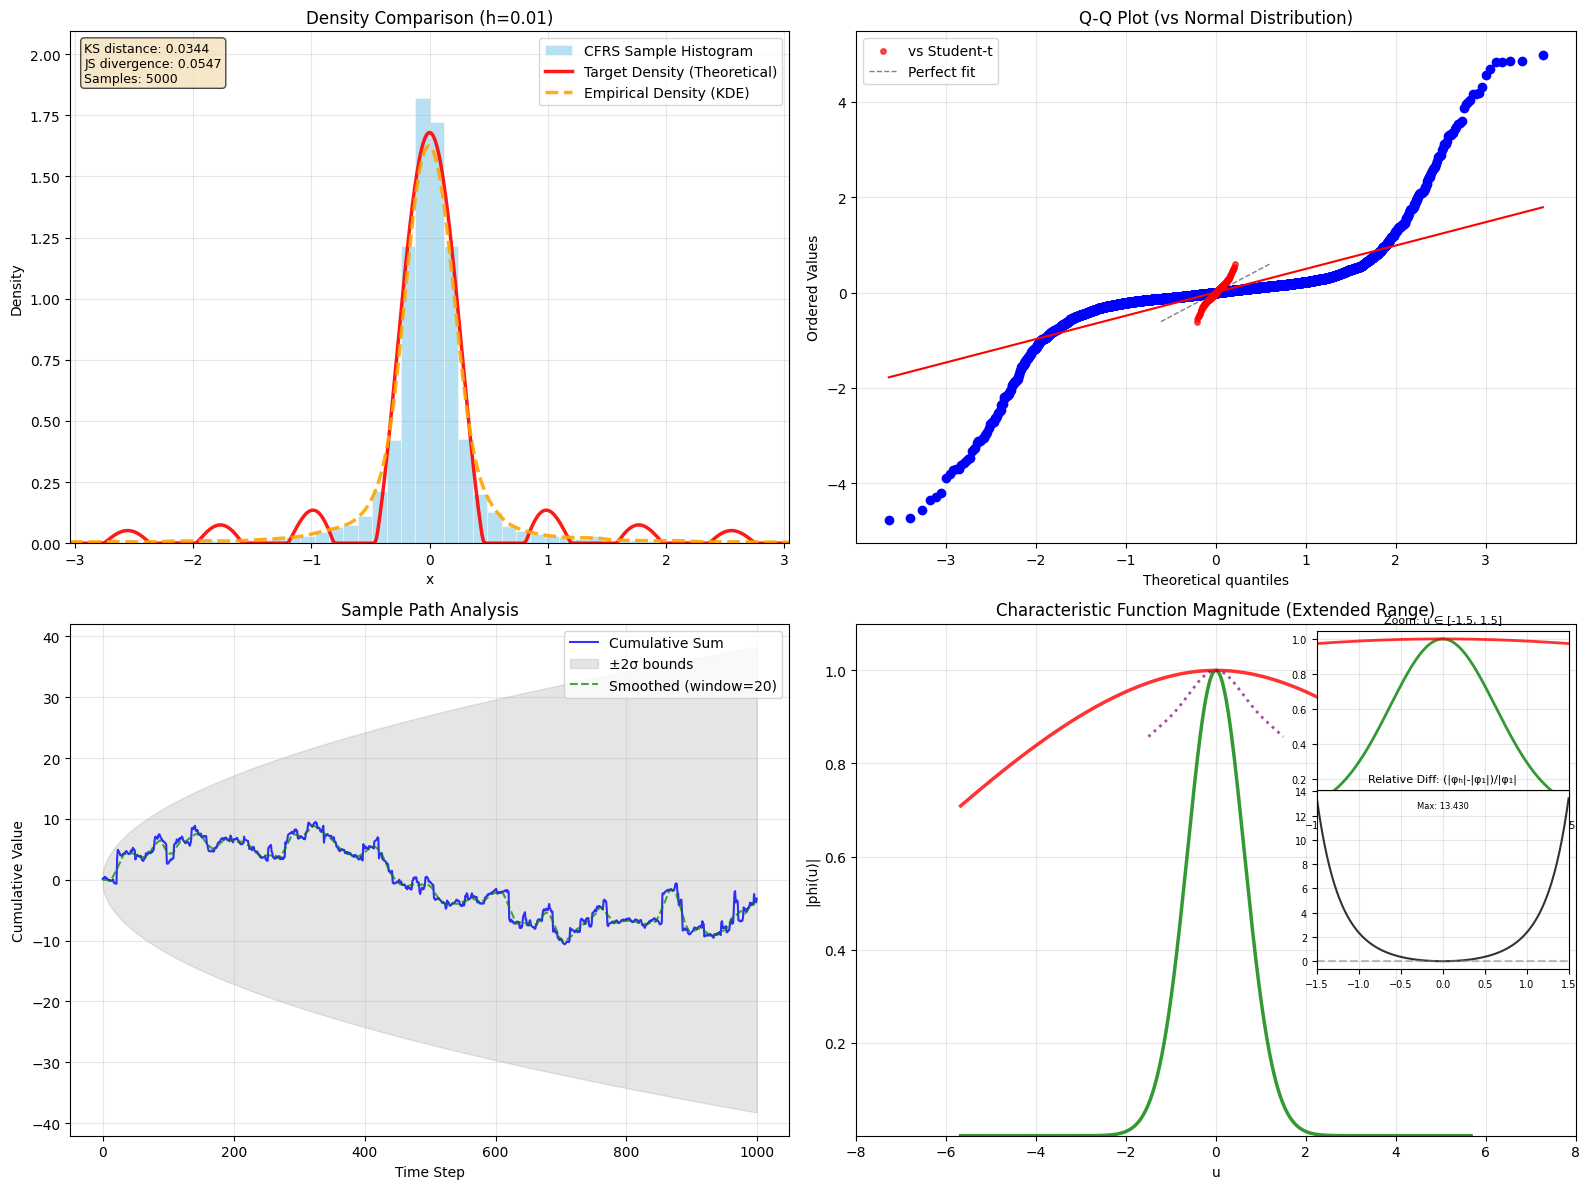


COMPREHENSIVE ANALYSIS SUMMARY
Sample Statistics:
  Count: 5000
  Mean: 0.005391
  Std:  0.604735
  Skewness: 0.448927
  Kurtosis: 21.291586

Theoretical Comparison (Student-t with ν=4.0, h=0.01):
  Expected mean: 0.000000
  Expected std: 0.141421
  Std ratio (sample/theory): 4.2761

Characteristic Function Analysis:
  u=0.5: |φₕ|/|φ₁| = 1.360046, expected ≈ 1.360046
  u=1.0: |φₕ|/|φ₁| = 3.356545, expected ≈ 3.356545
  u=2.0: |φₕ|/|φ₁| = 104.189953, expected ≈ 104.189953
Visualization completed


In [49]:
def compute_adaptive_x_range(samples, percentile_range=(1, 99), extension_factor=0.2):
    """
    Compute adaptive x-axis range based on sample distribution
    """
    if len(samples) == 0:
        return -5, 5
    
    # Use percentiles to avoid outliers
    x_min = np.percentile(samples, percentile_range[0])
    x_max = np.percentile(samples, percentile_range[1])
    
    # Extend the range
    x_range = x_max - x_min
    x_center = (x_max + x_min) / 2
    
    # Ensure minimum range
    if x_range < 1e-6:
        x_range = 1.0
    
    # Extend by factor
    extended_range = x_range * (1 + 2 * extension_factor)
    
    x_min_adaptive = x_center - extended_range / 2
    x_max_adaptive = x_center + extended_range / 2
    
    return x_min_adaptive, x_max_adaptive

def compute_optimal_bins(samples, max_bins=100):
    """
    Compute optimal number of bins using multiple methods
    """
    n = len(samples)
    if n < 10:
        return 10
    
    # Sturges' rule
    bins_sturges = int(np.ceil(np.log2(n) + 1))
    
    # Scott's rule
    h_scott = 3.5 * np.std(samples) / (n ** (1/3))
    x_min, x_max = compute_adaptive_x_range(samples)
    bins_scott = int(np.ceil((x_max - x_min) / h_scott))
    
    # Freedman-Diaconis rule
    iqr = np.percentile(samples, 75) - np.percentile(samples, 25)
    if iqr > 0:
        h_fd = 2 * iqr / (n ** (1/3))
        bins_fd = int(np.ceil((x_max - x_min) / h_fd))
    else:
        bins_fd = bins_sturges
    
    # Choose the median of the three methods, but cap at max_bins
    optimal_bins = int(np.median([bins_sturges, bins_scott, bins_fd]))
    return min(max(optimal_bins, 10), max_bins)

def visualize_results(samples, char_func, h):
    """Enhanced visualization with improved characteristic function display"""
    if len(samples) == 0:
        print("Warning: No samples to visualize")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Compute adaptive range for samples
    x_min_adaptive, x_max_adaptive = compute_adaptive_x_range(samples)
    optimal_bins = compute_optimal_bins(samples)
    
    print(f"Sample statistics:")
    print(f"  Count: {len(samples)}")
    print(f"  Mean: {np.mean(samples):.4f}")
    print(f"  Std: {np.std(samples):.4f}")
    print(f"  Range: [{np.min(samples):.4f}, {np.max(samples):.4f}]")
    print(f"  Adaptive range: [{x_min_adaptive:.4f}, {x_max_adaptive:.4f}]")
    
    # 1. Histogram vs Target Density vs Empirical Density
    ax1 = axes[0, 0]
    try:
        # Create grid for density calculations
        x_grid = np.linspace(x_min_adaptive, x_max_adaptive, 600)
        
        # Compute target density (theoretical)
        print("Computing target density...")
        target_density = compute_target_density(char_func, h, x_grid)
        
        # Compute empirical density using KDE (Kernel Density Estimation)
        print("Computing empirical density...")
        from scipy.stats import gaussian_kde
        
        # Use Gaussian KDE to estimate empirical density
        kde = gaussian_kde(samples)
        empirical_density = kde(x_grid)
        
        # Plot histogram - 修正归一化
        counts, bins, patches = ax1.hist(samples, bins=optimal_bins, 
                                        range=(x_min_adaptive, x_max_adaptive),
                                        density=True, alpha=0.6, 
                                        color='skyblue', label='CFRS Sample Histogram',
                                        edgecolor='white', linewidth=0.5)
        
        # 确保直方图正确归一化
        bin_width = bins[1] - bins[0]
        total_area_hist = np.sum(counts) * bin_width
        print(f"Histogram normalization check: {total_area_hist:.4f} (should be ~1)")
        
        # Plot target density (theoretical)
        if np.max(target_density) > 1e-10:
            ax1.plot(x_grid, target_density, 'r-', linewidth=2.5, 
                    label='Target Density (Theoretical)', alpha=0.9)
        else:
            print("Warning: Target density computation failed")
            
        # Plot empirical density (KDE)
        ax1.plot(x_grid, empirical_density, 'orange', linewidth=2.5,
                label='Empirical Density (KDE)', alpha=0.9, linestyle='--')
        
        ax1.set_xlim(x_min_adaptive, x_max_adaptive)
        
        # Improve y-axis limits to show all curves clearly
        all_densities = []
        if np.max(target_density) > 0:
            all_densities.append(np.max(target_density))
        all_densities.append(np.max(empirical_density))
        if len(counts) > 0:
            all_densities.append(np.max(counts))
        
        y_max = max(all_densities) * 1.15
        ax1.set_ylim(0, y_max)
        
        # Calculate and display similarity metrics
        target_interp = np.interp(x_grid, x_grid, target_density)
        
        # Compute Kolmogorov-Smirnov distance
        dx = x_grid[1] - x_grid[0]
        target_cdf = np.cumsum(target_interp) * dx
        empirical_cdf = np.cumsum(empirical_density) * dx
        ks_distance = np.max(np.abs(target_cdf - empirical_cdf))
        
        # Compute Jensen-Shannon divergence (approximate)
        def js_divergence(p, q):
            p = p / (np.sum(p) + 1e-12)
            q = q / (np.sum(q) + 1e-12)
            m = (p + q) / 2
            return 0.5 * np.sum(p * np.log((p + 1e-12) / (m + 1e-12))) + \
                   0.5 * np.sum(q * np.log((q + 1e-12) / (m + 1e-12)))
        
        js_div = js_divergence(target_interp + 1e-12, empirical_density + 1e-12)
        
        # Add text box with similarity metrics
        textstr = f'KS distance: {ks_distance:.4f}\nJS divergence: {js_div:.4f}\nSamples: {len(samples)}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
            
    except Exception as e:
        print(f"Error in density computation: {e}")
        ax1.hist(samples, bins=optimal_bins, 
                range=(x_min_adaptive, x_max_adaptive),
                density=True, alpha=0.7, 
                color='skyblue', label='CFRS Sample Histogram')
        ax1.set_xlim(x_min_adaptive, x_max_adaptive)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Density Comparison (h={h})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Q-Q Plot with additional distribution comparisons
    ax2 = axes[0, 1]
    try:
        # Q-Q plot against normal distribution
        stats.probplot(samples, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot (vs Normal Distribution)')
        ax2.grid(True, alpha=0.3)
        
        # Add theoretical quantiles for Student-t distribution
        try:
            from scipy.stats import t as student_t
            # 使用理论Student-t分布参数
            effective_df = char_func.nu
            effective_scale = char_func.sigma * np.sqrt(h)
            
            # 生成理论Student-t样本进行比较
            n_comparison = min(200, len(samples))
            sample_quantiles = np.percentile(samples, np.linspace(5, 95, n_comparison))
            theoretical_quantiles = student_t.ppf(np.linspace(0.05, 0.95, n_comparison), 
                                                df=effective_df, 
                                                loc=char_func.mu, 
                                                scale=effective_scale)
            
            ax2.scatter(theoretical_quantiles, sample_quantiles, 
                       color='red', alpha=0.7, s=15, label='vs Student-t', zorder=3)
            
            # 添加对角线参考
            all_vals = np.concatenate([theoretical_quantiles, sample_quantiles])
            diag_min, diag_max = np.min(all_vals), np.max(all_vals)
            ax2.plot([diag_min, diag_max], [diag_min, diag_max], 
                    'k--', alpha=0.5, linewidth=1, label='Perfect fit')
            
            ax2.legend()
            
        except Exception as e:
            print(f"Could not add Student-t Q-Q comparison: {e}")
            
    except Exception as e:
        print(f"Error in Q-Q plot: {e}")
        ax2.text(0.5, 0.5, 'Q-Q Plot Error', ha='center', va='center', transform=ax2.transAxes)
    
    # 3. Sample Trajectory with enhanced statistics
    ax3 = axes[1, 0]
    n_plot = min(1000, len(samples))
    cumsum = np.cumsum(samples[:n_plot])
    time_steps = np.arange(n_plot)
    
    # Theoretical bounds for random walk
    theoretical_std = np.sqrt(time_steps + 1) * np.std(samples)
    
    ax3.plot(time_steps, cumsum, 'b-', alpha=0.8, linewidth=1.5, label='Cumulative Sum')
    ax3.fill_between(time_steps, -2*theoretical_std, 2*theoretical_std, 
                     alpha=0.2, color='gray', label='±2σ bounds')
    
    # Add running mean
    window_size = max(10, n_plot // 50)
    if window_size < n_plot:
        running_mean = np.convolve(samples[:n_plot], np.ones(window_size)/window_size, mode='same')
        running_cumsum = np.cumsum(running_mean)
        ax3.plot(time_steps, running_cumsum, 'g--', alpha=0.7, linewidth=1.5, 
                 label=f'Smoothed (window={window_size})')
    
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Cumulative Value')
    ax3.set_title('Sample Path Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Enhanced Characteristic Function Visualization - 主要改进在这里
    ax4 = axes[1, 1]
    try:
        # 扩大u轴范围
        u_vals_wide = np.linspace(-8, 8, 800)  # 主要范围
        u_vals_zoom = np.linspace(-1.5, 1.5, 300)  # 局部放大范围
        
        print("Computing characteristic functions over extended range...")
        
        # 计算宽范围的特征函数
        phi_1_wide = np.array([char_func.phi(u) for u in u_vals_wide])
        phi_h_wide = np.array([char_func.phi_h(u, h) for u in u_vals_wide])
        
        # 计算局部范围的特征函数（更高精度）
        phi_1_zoom = np.array([char_func.phi(u) for u in u_vals_zoom])
        phi_h_zoom = np.array([char_func.phi_h(u, h) for u in u_vals_zoom])
        
        # Calculate magnitudes
        mag_phi_1_wide = np.abs(phi_1_wide)
        mag_phi_h_wide = np.abs(phi_h_wide)
        mag_phi_1_zoom = np.abs(phi_1_zoom)
        mag_phi_h_zoom = np.abs(phi_h_zoom)
        
        # Check for finite values
        mask_wide = np.isfinite(mag_phi_1_wide) & np.isfinite(mag_phi_h_wide) & \
                    (mag_phi_1_wide > 1e-15) & (mag_phi_h_wide > 1e-15)
        mask_zoom = np.isfinite(mag_phi_1_zoom) & np.isfinite(mag_phi_h_zoom)
        
        if np.any(mask_wide):
            # 主图：使用线性刻度显示局部差异
            ax4.plot(u_vals_wide[mask_wide], mag_phi_1_wide[mask_wide], 'g-', 
                    label='|phi_1(u)|', linewidth=2.5, alpha=0.8)
            ax4.plot(u_vals_wide[mask_wide], mag_phi_h_wide[mask_wide], 'r-', 
                    label=f'|phi_{h}(u)|', linewidth=2.5, alpha=0.8)
            
            # 计算并添加经验特征函数
            if len(samples) > 50:
                print("Computing empirical characteristic function...")
                # 只在较小的u范围内计算经验特征函数（计算成本考虑）
                u_empirical = u_vals_zoom
                emp_phi = np.zeros_like(u_empirical, dtype=complex)
                for i, u in enumerate(u_empirical):
                    emp_phi[i] = np.mean(np.exp(1j * u * samples))
                
                emp_mag = np.abs(emp_phi)
                emp_mask = np.isfinite(emp_mag)
                
                if np.any(emp_mask):
                    ax4.plot(u_empirical[emp_mask], emp_mag[emp_mask], 'purple', 
                            label='Empirical |phi(u)|', linewidth=2, alpha=0.7, linestyle=':')
            
            # 设置主图属性
            ax4.set_xlabel('u')
            ax4.set_ylabel('|phi(u)|')
            ax4.set_title('Characteristic Function Magnitude (Extended Range)')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            ax4.set_xlim(-8, 8)
            
            # 设置y轴范围（线性刻度）
            all_mags = np.concatenate([mag_phi_1_wide[mask_wide], mag_phi_h_wide[mask_wide]])
            y_min = max(np.min(all_mags) * 0.9, 1e-6)
            y_max = min(np.max(all_mags) * 1.1, 2.0)
            ax4.set_ylim(y_min, y_max)
            
            # 添加局部放大插图
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            
            # 插图1：局部放大（线性刻度）
            axins1 = inset_axes(ax4, width="35%", height="35%", loc='upper right')
            if np.any(mask_zoom):
                axins1.plot(u_vals_zoom[mask_zoom], mag_phi_1_zoom[mask_zoom], 'g-', 
                           linewidth=2, alpha=0.8, label='|phi_1|')
                axins1.plot(u_vals_zoom[mask_zoom], mag_phi_h_zoom[mask_zoom], 'r-', 
                           linewidth=2, alpha=0.8, label='|phi_h|')
                
                axins1.set_xlim(-1.5, 1.5)
                axins1.set_title('Zoom: u ∈ [-1.5, 1.5]', fontsize=8)
                axins1.grid(True, alpha=0.3)
                axins1.tick_params(labelsize=7)
            
            # 插图2：相对差异
            axins2 = inset_axes(ax4, width="35%", height="35%", loc='center right')
            if np.any(mask_zoom):
                relative_diff = (mag_phi_h_zoom[mask_zoom] - mag_phi_1_zoom[mask_zoom]) / \
                               (mag_phi_1_zoom[mask_zoom] + 1e-15)
                
                axins2.plot(u_vals_zoom[mask_zoom], relative_diff, 'black', 
                           linewidth=1.5, alpha=0.8)
                axins2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                axins2.set_xlim(-1.5, 1.5)
                axins2.set_title('Relative Diff: (|φₕ|-|φ₁|)/|φ₁|', fontsize=8)
                axins2.grid(True, alpha=0.3)
                axins2.tick_params(labelsize=7)
                
                # 显示最大相对差异
                max_rel_diff = np.max(np.abs(relative_diff))
                axins2.text(0.5, 0.9, f'Max: {max_rel_diff:.3f}', 
                           transform=axins2.transAxes, fontsize=6, ha='center')
            
        else:
            ax4.text(0.5, 0.5, 'Characteristic Function\nComputation Error', 
                    ha='center', va='center', transform=ax4.transAxes)
            
    except Exception as e:
        print(f"Error in characteristic function plot: {e}")
        ax4.text(0.5, 0.5, f'Char Func Error:\n{str(e)[:50]}...', 
                ha='center', va='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary statistics
    print("\n" + "="*60)
    print("COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*60)
    if len(samples) > 0:
        print(f"Sample Statistics:")
        print(f"  Count: {len(samples)}")
        print(f"  Mean: {np.mean(samples):.6f}")
        print(f"  Std:  {np.std(samples):.6f}")
        print(f"  Skewness: {stats.skew(samples):.6f}")
        print(f"  Kurtosis: {stats.kurtosis(samples):.6f}")
        
        # 比较理论值
        print(f"\nTheoretical Comparison (Student-t with ν={char_func.nu}, h={h}):")
        theoretical_mean = char_func.mu * h
        print(f"  Expected mean: {theoretical_mean:.6f}")
        
        if char_func.nu > 2:
            theoretical_var = char_func.nu * (char_func.sigma**2) * h / (char_func.nu - 2)
            theoretical_std = np.sqrt(theoretical_var)
            print(f"  Expected std: {theoretical_std:.6f}")
            print(f"  Std ratio (sample/theory): {np.std(samples)/theoretical_std:.4f}")
        
        if char_func.nu > 4:
            theoretical_kurtosis = 6 / (char_func.nu - 4)
            print(f"  Expected excess kurtosis: {theoretical_kurtosis:.6f}")
            print(f"  Sample excess kurtosis: {stats.kurtosis(samples):.6f}")
        
        # 特征函数差异统计
        print(f"\nCharacteristic Function Analysis:")
        try:
            u_test = np.array([0.5, 1.0, 2.0])
            phi_1_test = [char_func.phi(u) for u in u_test]
            phi_h_test = [char_func.phi_h(u, h) for u in u_test]
            
            for i, u in enumerate(u_test):
                ratio = np.abs(phi_h_test[i]) / np.abs(phi_1_test[i])
                expected_ratio = np.abs(phi_1_test[i])**(h-1)
                print(f"  u={u}: |φₕ|/|φ₁| = {ratio:.6f}, expected ≈ {expected_ratio:.6f}")
        except:
            print("  Could not compute characteristic function ratios")

print("Complete enhanced visualization function defined")

# Generate visualization
print("Starting visualization with adaptive ranges...")
visualize_results(samples, char_func, h)
print("Visualization completed")

In [50]:
def performance_test(char_func, h_values, n_samples=1000):
    """测试不同h值下的性能"""
    results = []
    
    for h in h_values:
        print(f"\n测试 h={h}")
        start_time = time.time()
        samples = cfrs_sampler(char_func, h, n_samples)
        end_time = time.time()
        
        if len(samples) > 0:
            sample_mean = np.mean(samples)
            sample_std = np.std(samples)
            execution_time = end_time - start_time
            
            results.append({
                'h': h,
                'n_samples': len(samples),
                'sample_mean': sample_mean,
                'sample_std': sample_std,
                'execution_time': execution_time
            })
    
    return results

# 性能测试
import time
h_values = [0.01, 0.1, 0.5, 1.0]
performance_results = performance_test(char_func, h_values)

# 显示结果
print("\n=== 性能测试结果 ===")
for result in performance_results:
    print(f"h={result['h']:4.2f}: {result['n_samples']:4d}样本, "
          f"均值={result['sample_mean']:8.4f}, "
          f"标准差={result['sample_std']:8.4f}, "
          f"耗时={result['execution_time']:6.2f}秒")
    


测试 h=0.01
Target: 1000 samples, max attempts: 50000
Integration range: [-3, 3], points: 500
phi_h max: 1.000000
Constants: c=0.922613, k=0.018551
Theoretical acceptance rate: 30.5751
Generated 200 samples, rate: 0.9950
Generated 400 samples, rate: 0.9901
Generated 600 samples, rate: 0.9852
Generated 800 samples, rate: 0.9877
Generated 1000 samples, rate: 0.9872
Final: 1014 attempts, 1000 accepted, rate: 0.9862

测试 h=0.1
Target: 1000 samples, max attempts: 50000
Integration range: [-3, 3], points: 500
phi_h max: 0.999995
Constants: c=0.703621, k=0.104697
Theoretical acceptance rate: 14.7375
Generated 200 samples, rate: 0.9756
Generated 400 samples, rate: 0.9592
Generated 600 samples, rate: 0.9646
Generated 800 samples, rate: 0.9604
Generated 1000 samples, rate: 0.9597
Final: 1043 attempts, 1000 accepted, rate: 0.9588

测试 h=0.5
Target: 1000 samples, max attempts: 50000
Integration range: [-3, 3], points: 500
phi_h max: 0.999977
Constants: c=0.363732, k=0.414574
Theoretical acceptance ra